# Predicting Hotel Cancellations

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

March 2022




## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import statsmodels as sm
from math import ceil
from datetime import timedelta
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import graphviz

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer

In [3]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.21.2
Scipy version  1.7.1
Seaborn version  0.11.2


In [4]:
COLORS = ['#22446d', '#446f8b', '#689ea6', '#94cdbc', '#e6f9af', '#f5b68e', '#eb756f', '#cb3553', '#93003a']

CAT_COLORS = ['#22446D', '#6ABB5D', '#F3E97B', '#FC9E4F', '#AB2346']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False
RANDOM_STATE = 9

show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [5]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 70

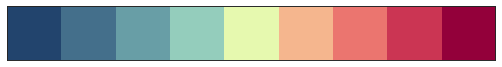

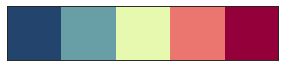

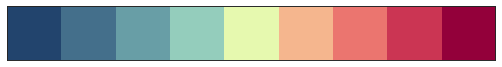

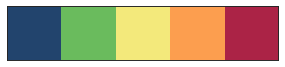

In [6]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Define some helper functions

In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [8]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [9]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




In [10]:
df = pd.read_csv('../../source/H2.csv')

## Remove last row
#df.drop(df.tail(1).index,inplace=True)
#df['Custid'] = df['Custid'].astype(int)
#df.set_index('Custid', inplace=True)

df_original = df.copy(deep=True)

df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30


## Data Preprocessing

### Convert types

In [11]:
MONTHS = ['January', 'February', 'March', 'April', 'May','June',
          'July','August','September','October','November','December']

MONTH_NUMS = [i+1 for i in range(12)]

df['ArrivalDateMonthNumber'] = df['ArrivalDateMonth'].replace(to_replace=MONTHS, value=MONTH_NUMS)
df.loc[:,['ArrivalDateMonth','ArrivalDateMonthNumber']]

,ArrivalDateMonth,ArrivalDateMonthNumber
0,July,7
1,July,7
2,July,7
3,July,7
4,July,7
...,...,...
79325,August,8
79326,August,8
79327,August,8
79328,August,8


In [12]:
df['ArrivalDate'] = df['ArrivalDateYear'].astype(str) + '-' + df['ArrivalDateMonthNumber'].astype(str) + '-' + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
# df['ArrivalDate']

In [13]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
# print(df.dtypes)


### Check nulls

In [14]:
df['Company'] = df['Company'].replace('       NULL', np.nan)

In [15]:
df['Company'][0]

nan

In [16]:
df.isna().sum()

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           4
Babies                             0
Meal                               0
Country                           24
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                              0
Company                        75641
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Drop Company because too many nulls

In [17]:
df.drop(columns=['Company'],inplace=True)

Impute missing values for Country and Children with modes

In [18]:
df['Country'].fillna(value=df['Country'].mode()[0], inplace=True)

In [19]:
df['Children'].fillna(value=df['Children'].mode()[0], inplace=True)

In [20]:
#df.isna().sum()

### Check duplicates

In [21]:
## duplicates kept
df_hasdups = df.copy()

## duplicated rows
df_dups = df[df.duplicated(keep=False)]

## duplicates removed
df.drop_duplicates(keep='first', inplace=True)

### Separate numeric and non-numeric features

In [22]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

In [23]:
cat_feats = df.columns.drop(num_feats).to_list()
cat_feats

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDate']

In [24]:
num_feats.remove('IsCanceled')
num_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

### Check Outliers

### Check strange values

In [25]:
## Fix Country Code 'CN' as CHN
df.loc[df['Country']=='CN',['Country']] = 'CHN'
df.loc[df['Country']=='CN',['Country']]


,Country


## Time Series Analysis

In [26]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate'],
      dtype='object')

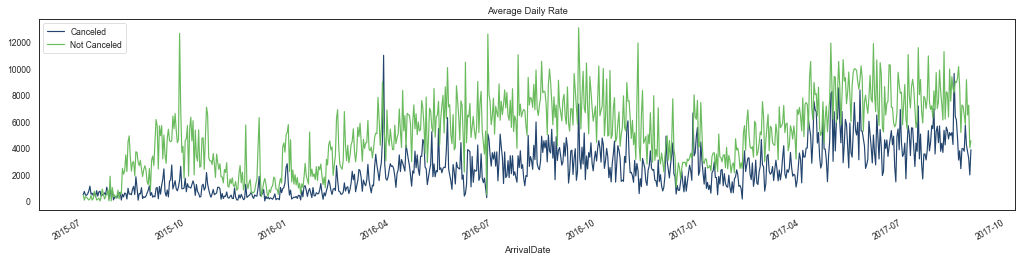

In [27]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

In [28]:
df_ts.loc[df_ts['ArrivalDate']=='2016-04-01',['ArrivalDate','ADR','ADR_Diff','IsCanceled']].groupby(['IsCanceled']).sum()

,ADR,ADR_Diff
IsCanceled,,
0,4587.76,4587.76
1,2604.71,2604.71


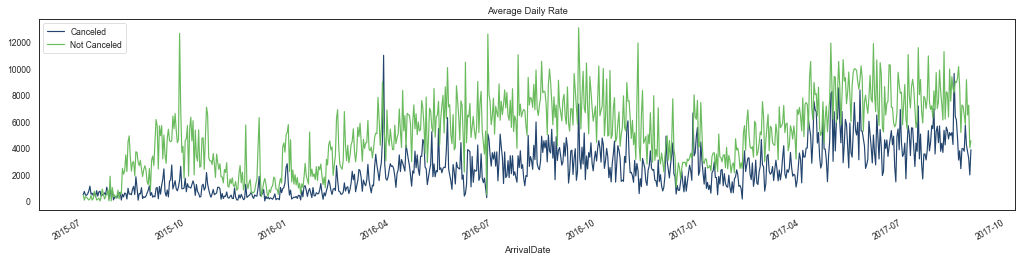

In [29]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

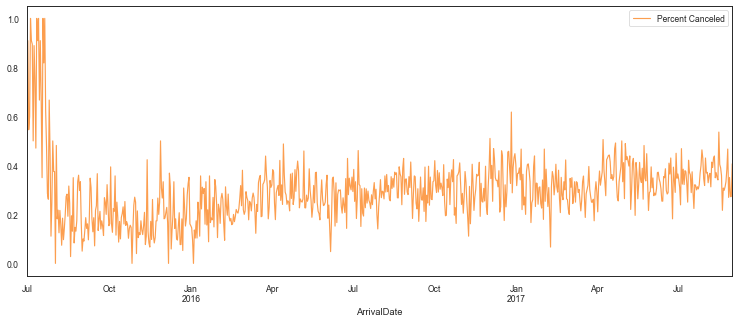

In [30]:
df_ts2 = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_ts2 = df_ts2.T.reset_index(drop=True).T.replace(np.nan,0)
df_ts2['total'] = df_ts2[0]+df_ts2[1]
df_ts2['diff'] = df_ts2[0]-df_ts2[1]

df_ts2['percentCanceled'] = df_ts2[1]/df_ts2['total']

fig, ax = plt.subplots(figsize=(13,5))

df_ts2['percentCanceled'].plot(ax=ax, color=CAT_COLORS[3], label='Percent Canceled')

plt.legend()
plt.show()

In [31]:
import statsmodels.api as sm


In [32]:
endog = df_ts2['percentCanceled']
endog.index = pd.period_range('2015-07-01','2017-08-31',freq='D')

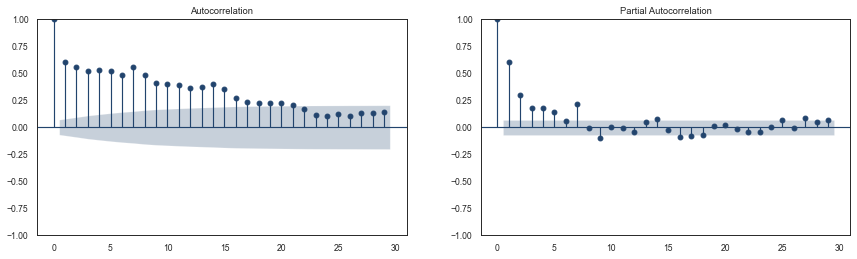

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

sm.graphics.tsa.plot_acf(endog, ax=axes[0])
sm.graphics.tsa.plot_pacf(endog, method="ywm", ax=axes[1])

plt.show()

In [34]:
## Construct SARIMAX Model

## Remove L6 as not significant
# mod = sm.tsa.SARIMAX(endog, order=([1, 2, 3, 4, 5, 6, 7], 0, 0), trend='c')

# Estimate the parameters
# res = mod.fit()

# endog_trim = endog.loc[:'2017-02-15']

## Construct the model on trimmed data
## Remove L6 as not significant
# mod_trim = sm.tsa.SARIMAX(endog_trim, order=([1, 2, 3, 4, 5, 7], 0, 0), trend='ct')

## Estimate the parameters
# res_trim = mod_trim.fit()

In [35]:
## Plots
# fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
## endog[:'2017-03-01'].plot(ax=ax, color=COLORS[1])

# Construct the forecasts

## Don't use these
#fcast = res.get_prediction(start='2017-09-01', end='2018-7-31').summary_frame()
#fcast = res.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()

## Use this
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-02-28').summary_frame()


#ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
#fcast['mean'].plot(ax=ax, color='r')

#plt.show()

## Feature Engineering

### Add regions for countries

In [36]:
## Data from https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv



In [37]:
## Fix TMP >> TLS
df.loc[df['Country']=='TMP',['Country']] = 'TLS'

In [38]:
country_info = pd.read_csv('../data_in/country_info.csv')
country_info.head(3)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN


In [39]:
# country_info.isna().sum()
# Drop nan region: Antarctica is not in dataset

In [40]:
country_info = country_info.loc[~country_info['region'].isna(),:]

In [41]:
df = pd.merge(df,country_info[['alpha-3','region','sub-region']],
              left_on='Country', right_on='alpha-3',
              how='left').drop(columns=['alpha-3'])

In [42]:
cat_feats.append('region')
cat_feats.append('sub-region')

In [43]:
df.loc[df['Country']=='ATA',['region']] = 'Antarctica'
df.loc[df['Country']=='ATA',['sub-region']] = 'Antarctica'

In [44]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

### Add Season column

In [45]:
## From https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


In [46]:
df['Season'] = df['ArrivalDate'].map(season_of_date)

In [47]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate', 'region', 'sub-region',
       'Season'],
      dtype='object')

In [48]:
cat_feats.append('Season')

In [49]:
df.loc[df['region'].isna(),['Country']]

,Country


### Percent cancellation lagged

In [50]:
df_pc = df[['IsCanceled']]
df_pc

,IsCanceled
0,0
1,1
2,1
3,1
4,1
...,...
53421,0
53422,0
53423,0
53424,0


In [51]:
df_pc = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_pc = df_pc.T.reset_index(drop=True).T.replace(np.nan,0)
df_pc['Total'] = df_pc[0]+df_pc[1]
df_pc['PctCanceledPrevWeek'] = df_pc[1]/df_pc['Total']

df_pc["ArrivalDate"] = df_pc.index + timedelta(days=7)
df_pc["PrevWeek"] = df_pc.index
df_pc.reset_index(drop=True, inplace=True)
df_pc.drop(columns=[0,1,'Total','PrevWeek'], inplace=True)
df_pc.head(3)

,PctCanceledPrevWeek,ArrivalDate
0,0.500000,2015-07-08
1,0.909091,2015-07-09
2,0.545455,2015-07-10


In [52]:
df = df.join(df_pc.set_index('ArrivalDate'), how='left', on='ArrivalDate')

In [53]:
df.head(20)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,region,sub-region,Season,PctCanceledPrevWeek
0,0,6,2015,July,27,1,0,2,1,0.0,...,0,0,Check-Out,2015-07-03,7,2015-07-01,Europe,Southern Europe,summer,NaN
1,1,88,2015,July,27,1,0,4,2,0.0,...,0,1,Canceled,2015-07-01,7,2015-07-01,Europe,Southern Europe,summer,NaN
2,1,65,2015,July,27,1,0,4,1,0.0,...,0,1,Canceled,2015-04-30,7,2015-07-01,Europe,Southern Europe,summer,NaN
3,1,92,2015,July,27,1,2,4,2,0.0,...,0,2,Canceled,2015-06-23,7,2015-07-01,Europe,Southern Europe,summer,NaN
4,1,100,2015,July,27,2,0,2,2,0.0,...,0,1,Canceled,2015-04-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
5,1,79,2015,July,27,2,0,3,2,0.0,...,0,1,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
6,0,3,2015,July,27,2,0,3,1,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-02,Europe,Southern Europe,summer,NaN
7,1,63,2015,July,27,2,1,3,1,0.0,...,0,0,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
8,1,62,2015,July,27,2,2,3,2,0.0,...,0,1,No-Show,2015-07-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
9,0,43,2015,July,27,3,0,2,2,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-03,Europe,Southern Europe,summer,NaN


In [54]:
df['PctCanceledPrevWeek'].fillna(method='bfill', inplace=True)

In [55]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

## Inspect variables: Check histograms

In [56]:
#plot_histograms_boxplots(df, num_feats, rows=3)

In [57]:
#plot_histograms_boxplots(df_hasdups, num_feats, rows=3, title="Histograms with Duplicates Preserved")

In [58]:
## Function to plot histograms of numeric features for specified dataframe, divided by target variable
def plot_histograms_boxplots_target(df, features, target, rows=4, title = "Histograms of Numeric Variables with Target"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns=target)[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=CAT_COLORS[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df[target]==0,feat], ax=axs[1], color=CAT_COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df[target]==1,feat], ax=axs[2], color=CAT_COLORS[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

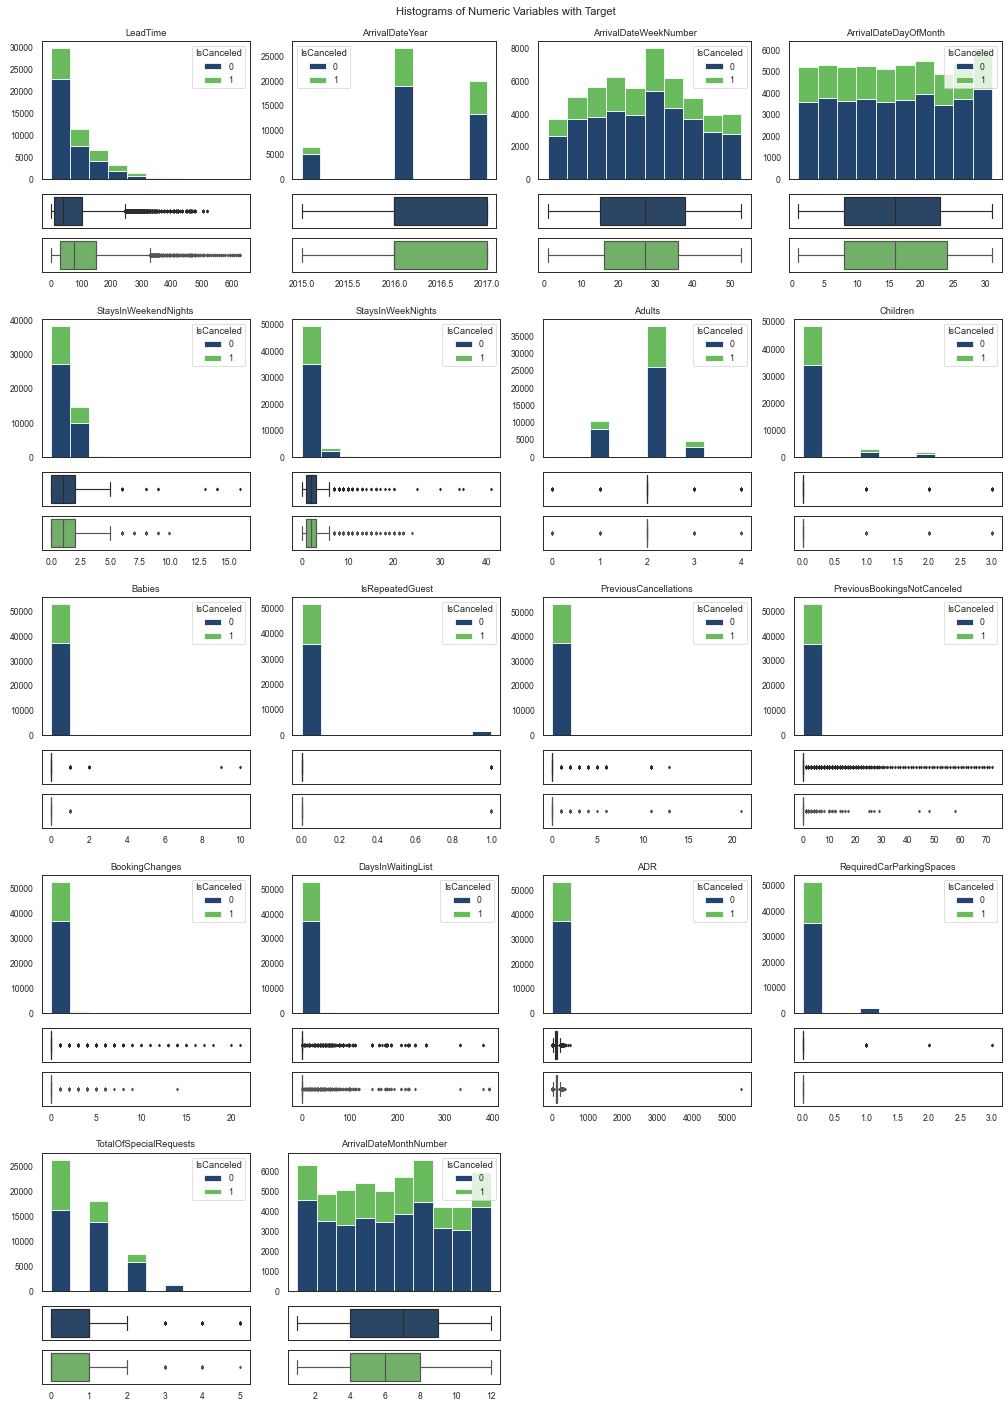

In [59]:
plot_histograms_boxplots_target(df, num_feats, 'IsCanceled', rows=5)

In [60]:
#plot_histograms_boxplots_target(df_hasdups, num_feats, 'IsCanceled', rows=5)

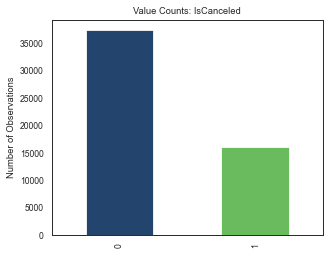

In [61]:
fig, ax = plt.subplots(figsize=(5,4))
df.groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2])
ax.set_xlabel(None)
ax.set_ylabel('Number of Observations')
ax.set_title('Value Counts: IsCanceled')
plt.show()

In [62]:
## Function to plot histograms of cat features for specified dataframe
def plot_cat_counts(df, features, target, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
        c = CAT_COLORS[0:2]
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,target]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=c)

            df2 = df.groupby([feat,target]).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=c)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

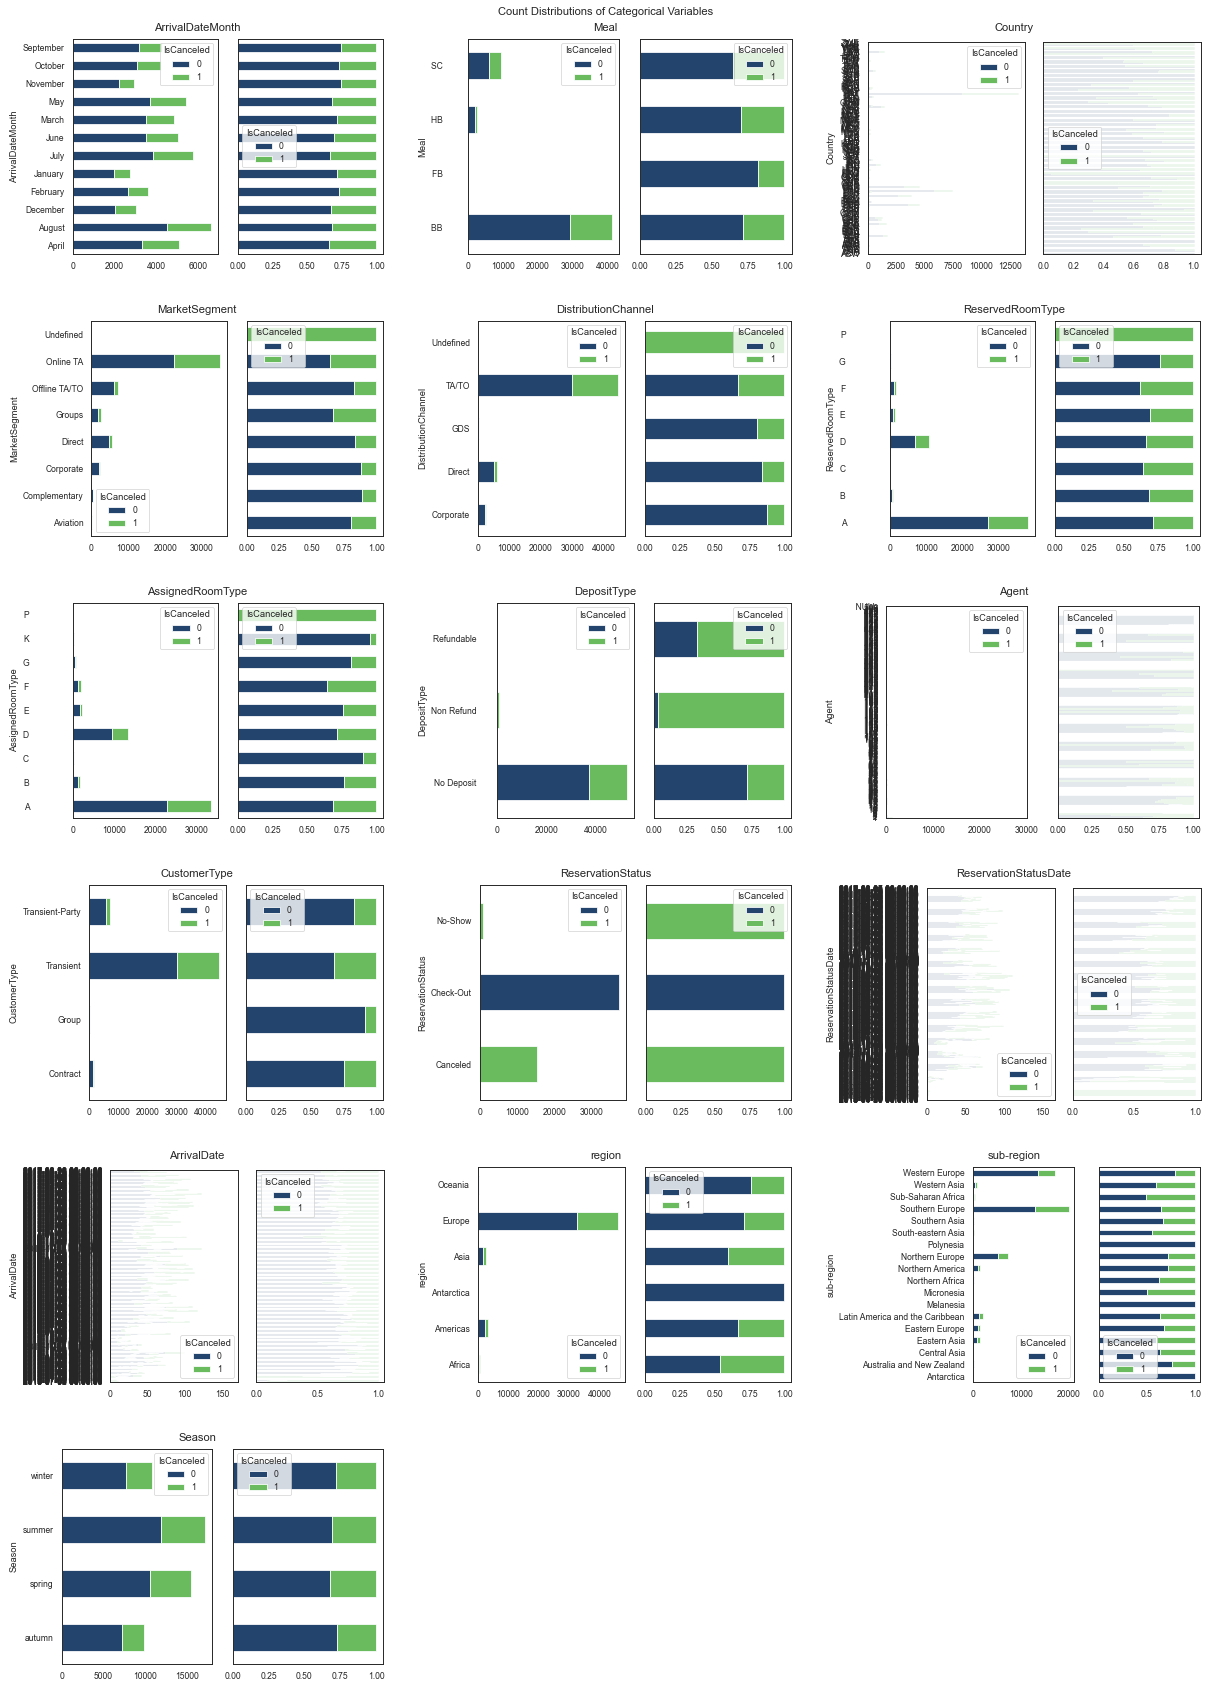

In [63]:
plot_cat_counts(df, cat_feats, 'IsCanceled', rows = 6)

In [64]:
# plot_cat_counts(df_hasdups, cat_feats, 'IsCanceled', rows = 6)

In [65]:
# aggregated and shape data

def show_barplot_compare(df, g1, g2) :
    if show_plots:
        
        df = df.sort_values(by=g2,ascending=False)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23,23))
 
        df1 = df.groupby([g1,g2]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=ax[0], color=CONTRAST_COLORS)

        # aggregated and shape data
        df2 = df.groupby([g1,g2]).size().unstack(1)
        df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=ax[1], color=CONTRAST_COLORS)
    
        plt.show()
        if SAVE_PLOTS:
            save_fig('Bar plot '+ g1 + ' ' + g2, fig)
            

In [66]:
def absolute_relative_histoplot(df, feat, target, title='Absolute and Relative Distributions of Canceled Status by Country', figsize=(21,28)):
    df_ar = df.groupby([feat,target]).size().unstack()
    df_ar = df_ar.T.reset_index(drop=True).T.replace(np.nan,0)
    df_ar['total'] = df_ar[0]+df_ar[1]
    df_ar.sort_values(by='total', inplace=True)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    df_ar[target] = df_ar[1]
    not_t = 'Not ' + target
    df_ar[not_t] = df_ar[0]

    df_ar.loc[:,[not_t, target]]\
                     .plot(kind="barh", width=1, stacked=True, ax=ax[1], color=CAT_COLORS)
    ax[1].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[1].set_title('Absolute Distribution', loc='left', fontsize=18)


    df_cc2 = df_ar.loc[:,[not_t, target]].div(df_ar['total'], axis=0)\
                    .plot(kind="barh", width=1, stacked=True, ax=ax[0], color=CAT_COLORS)
    ax[0].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[0].set_title('Relative Distribution', loc='left', fontsize=18)

    
    ax[0].yaxis.set_label_position("right")
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)

    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    

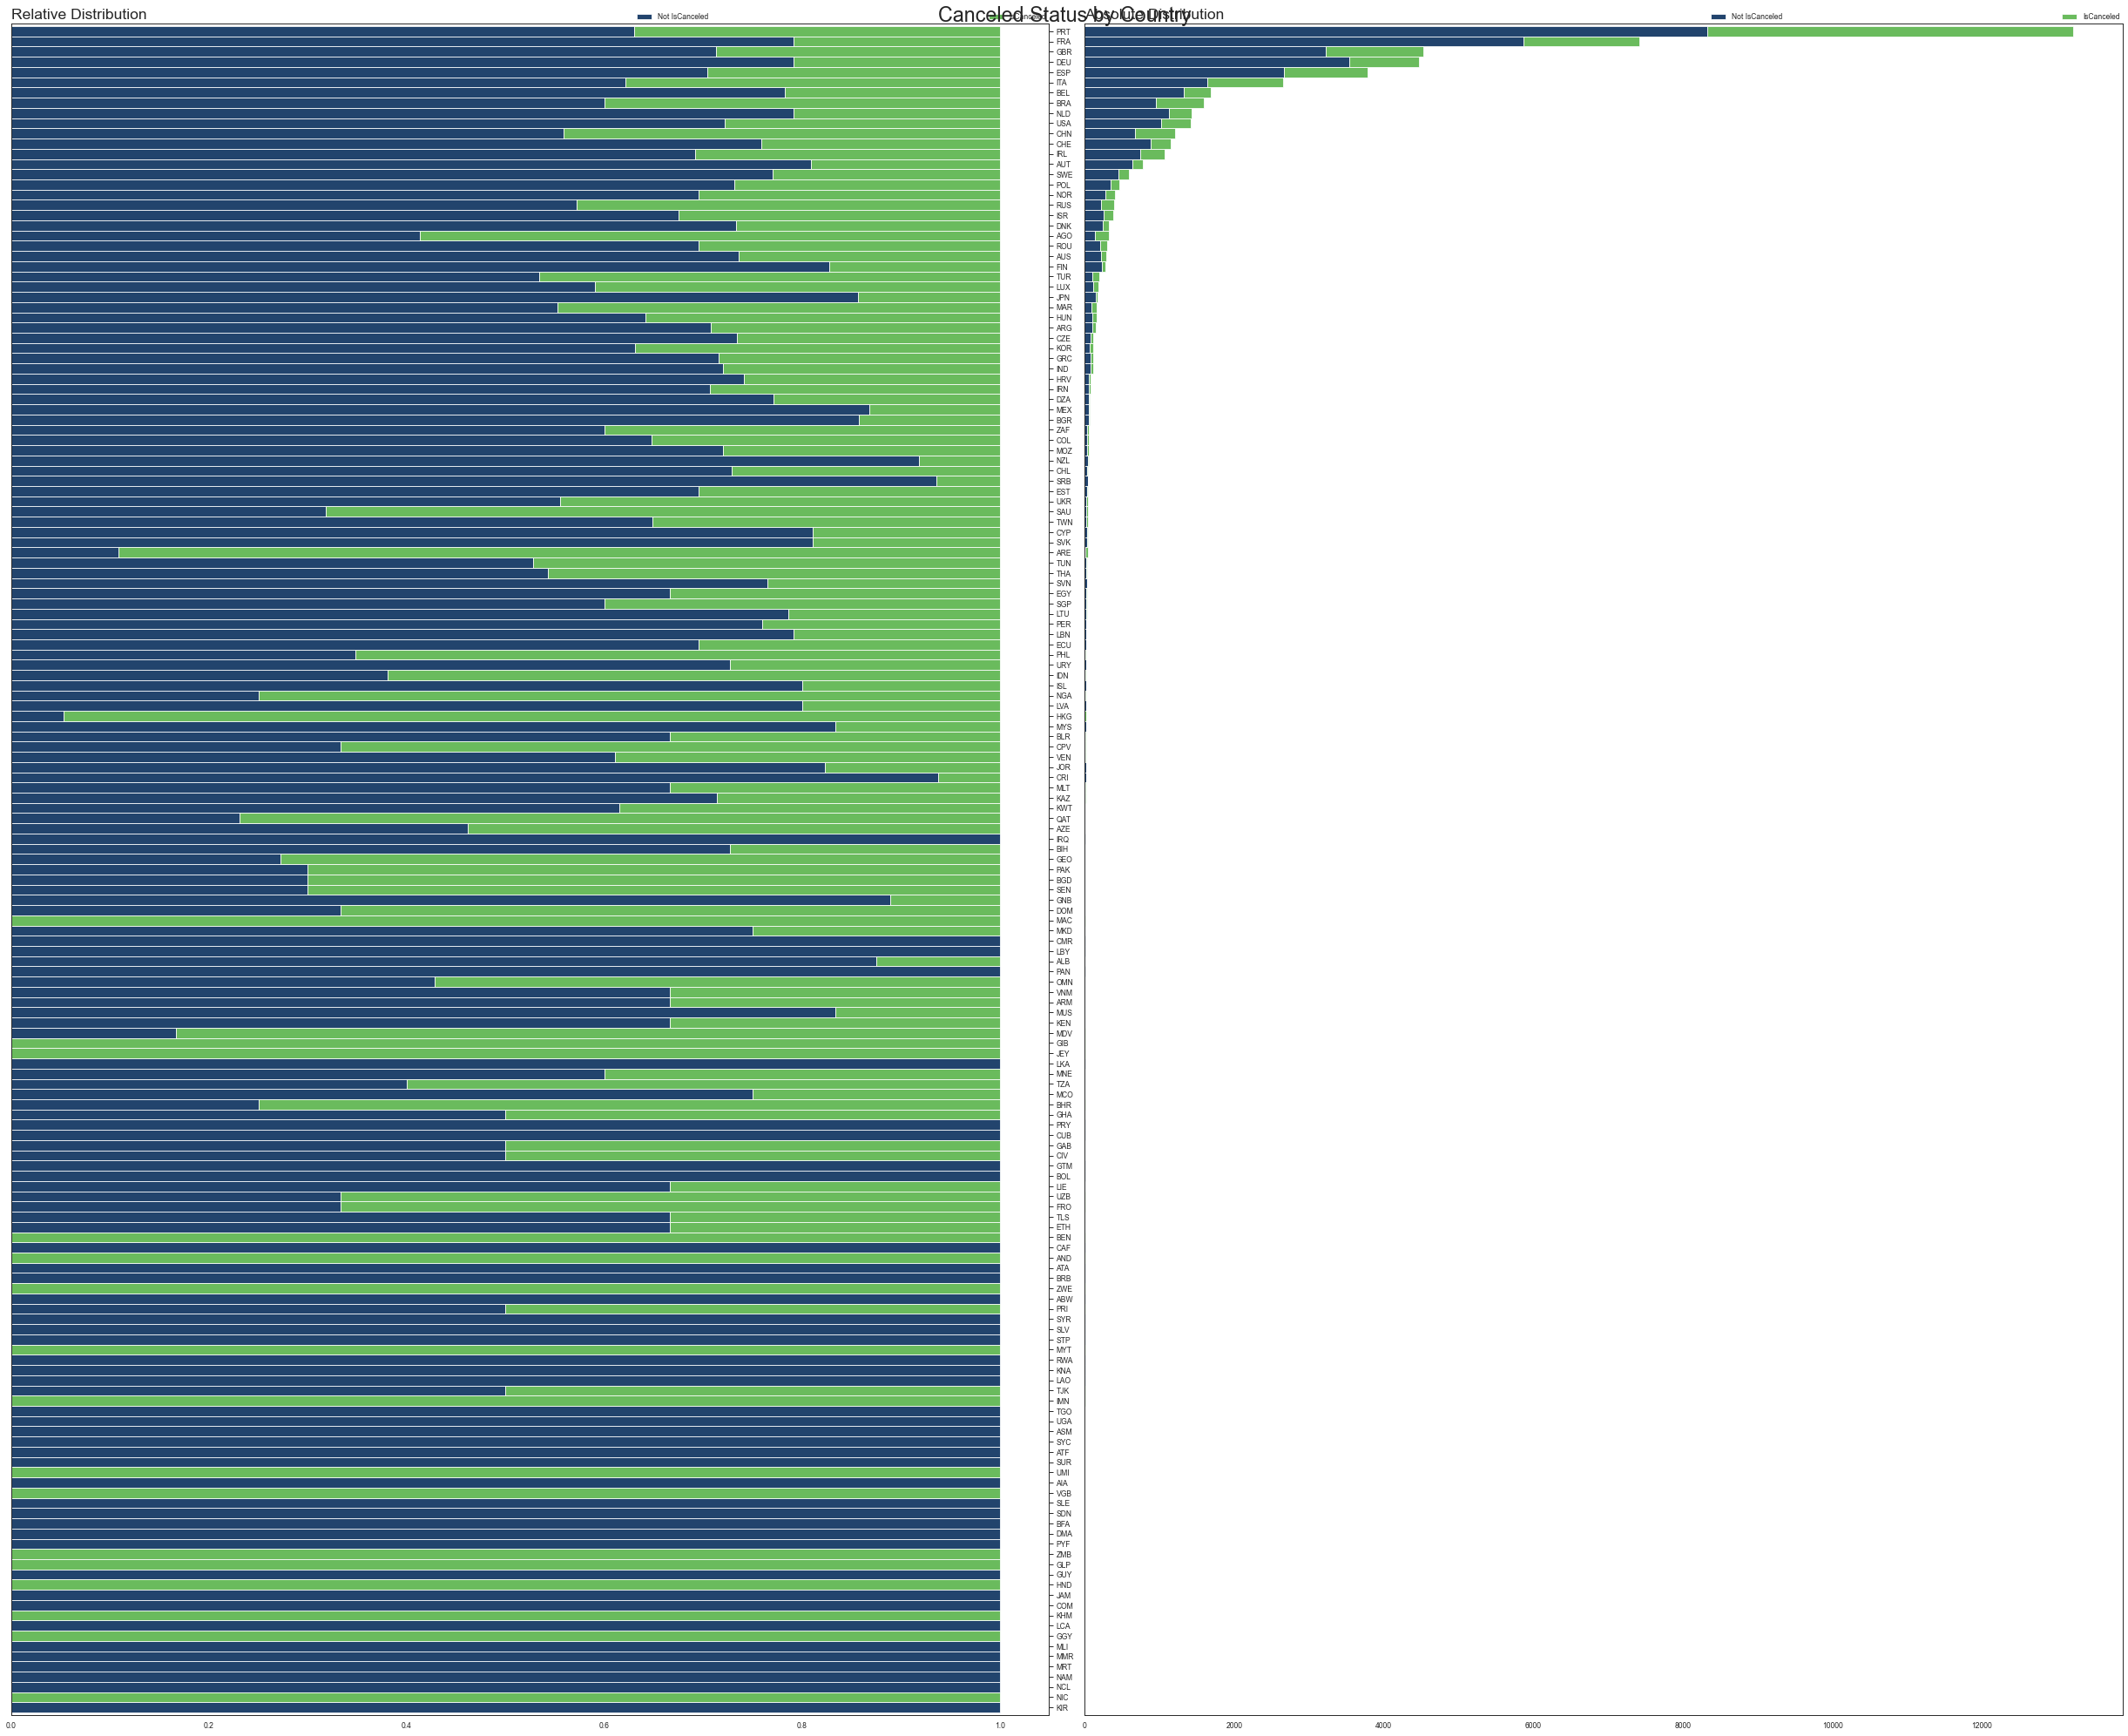

In [67]:
absolute_relative_histoplot(df, 'Country', 'IsCanceled', title='Canceled Status by Country', figsize=(35,29))


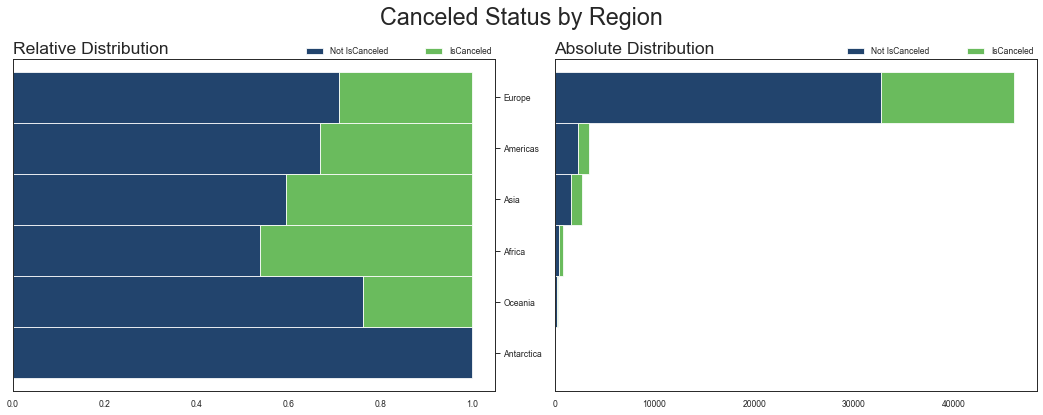

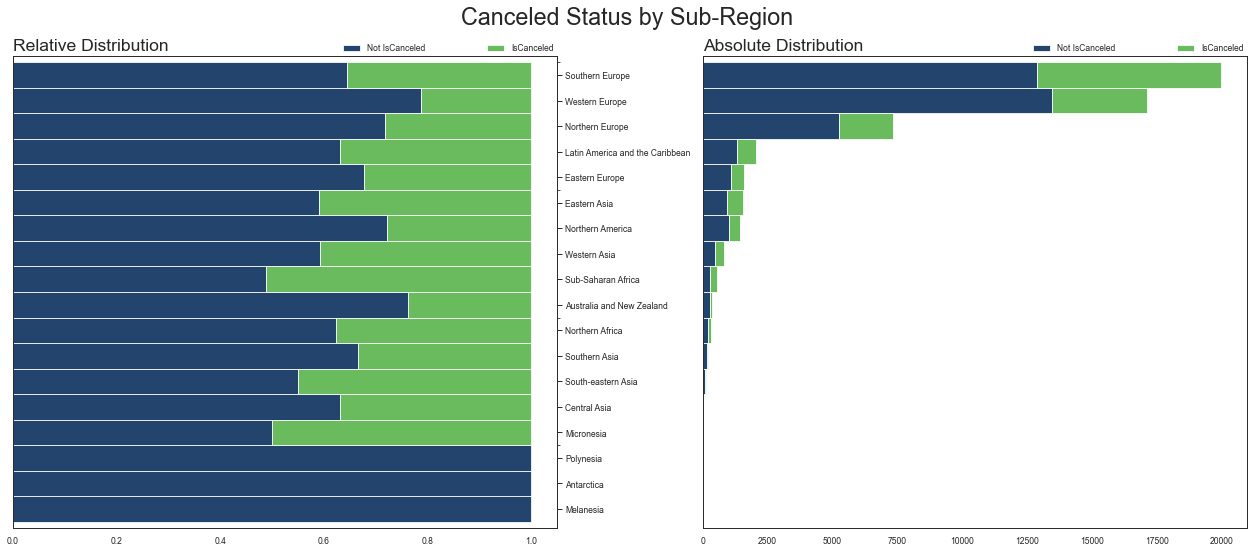

In [68]:
absolute_relative_histoplot(df, 'region', 'IsCanceled', title='Canceled Status by Region', figsize=(15,6))
absolute_relative_histoplot(df, 'sub-region', 'IsCanceled', title='Canceled Status by Sub-Region', figsize=(18,8))


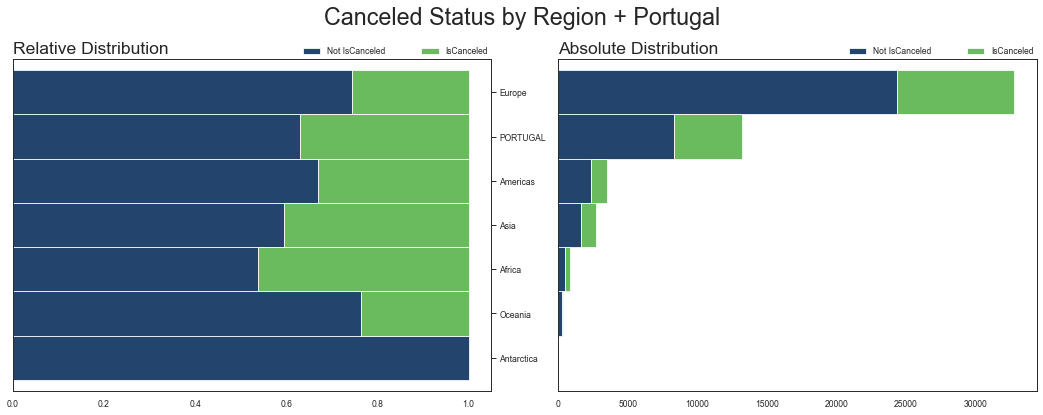

In [69]:
df['region alt'] = df['region']
df.loc[df['Country']=='PRT',['region alt']] = 'PORTUGAL'
absolute_relative_histoplot(df, 'region alt', 'IsCanceled', title='Canceled Status by Region + Portugal', figsize=(15,6))


## Feature Selection

In [70]:
df['RSday'] = df['ReservationStatusDate'].dt.day
df['RSmonth'] = df['ReservationStatusDate'].dt.month
df['RSyear'] = df['ReservationStatusDate'].dt.year


X = df.loc[:, df.columns != 'IsCanceled']
X.drop('ReservationStatus', 1, inplace=True)
X.drop('ReservationStatusDate', 1, inplace=True)
X.drop('ArrivalDate', 1, inplace=True)
X.drop('ArrivalDateMonth', 1, inplace=True)

X.drop('sub-region', 1, inplace=True)
X.drop('region', 1, inplace=True)

X.drop('Agent', 1, inplace=True) 
X.drop('Country', 1, inplace=True)

y = df['IsCanceled']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,
                                                  random_state = 9, stratify = y, shuffle = True)

In [71]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [72]:
categorical_features = ['ArrivalDateYear','ArrivalDateWeekNumber','ArrivalDateDayOfMonth','Meal','region','sub-region','Season','region alt','RSday','RSmonth','RSyear']

categorical_features=['Meal','MarketSegment','DistributionChannel','ReservedRoomType','AssignedRoomType','DepositType','CustomerType','Season','region alt']
numeric_features=['LeadTime','StaysInWeekendNights','StaysInWeekNights','Adults','Children','Babies','TotalOfSpecialRequests']

X_train_cat=X_train[categorical_features]
X_train_num=X_train[numeric_features]
X_val_cat=X_val[categorical_features]
X_val_num=X_val[numeric_features]

In [73]:
#train
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
# validation
X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

In [74]:
for var in X_train[categorical_features]:
    TestIndependence(X_train_cat[var],y_train, var)

Meal is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
Season is IMPORTANT for Prediction
region alt is IMPORTANT for Prediction


## Filter Methods

In [75]:
X_train_num.var()

LeadTime                       6753.610852
ArrivalDateYear                   0.434446
ArrivalDateWeekNumber           183.863059
ArrivalDateDayOfMonth            77.704918
StaysInWeekendNights              0.835280
StaysInWeekNights                 2.627637
Adults                            0.294968
Children                          0.194046
Babies                            0.009841
IsRepeatedGuest                   0.031209
PreviousCancellations             0.143844
PreviousBookingsNotCanceled       3.666945
BookingChanges                    0.497218
DaysInWaitingList               137.504914
ADR                            1777.728303
RequiredCarParkingSpaces          0.033320
TotalOfSpecialRequests            0.690021
ArrivalDateMonthNumber            9.408037
PctCanceledPrevWeek               0.009480
RSday                            76.632035
RSmonth                          10.290132
RSyear                            0.426637
dtype: float64

In [76]:
all_train_num = X_train_num.join(y_train)
all_train_num.head()

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,...,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ArrivalDateMonthNumber,PctCanceledPrevWeek,RSday,RSmonth,RSyear,IsCanceled
17602,77,2017,30,25,0,4,2,0.0,0,0,...,0,106.60,0,0,7,0.292683,18,7,2017,1
11897,199,2016,53,29,0,3,2,0.0,0,0,...,0,107.10,0,0,12,0.454545,29,12,2016,1
33880,126,2016,35,24,0,3,2,0.0,0,0,...,0,121.13,1,0,8,0.372340,27,8,2016,0
52517,73,2017,33,14,1,3,3,0.0,0,0,...,0,200.00,0,0,8,0.312500,18,8,2017,0
45410,53,2017,15,13,1,3,2,0.0,0,0,...,0,139.50,0,1,4,0.344444,17,4,2017,0


In [77]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_spearman = all_train_num.corr(method ='spearman')
cor_spearman

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,...,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ArrivalDateMonthNumber,PctCanceledPrevWeek,RSday,RSmonth,RSyear,IsCanceled
LeadTime,1.000000,0.180261,0.075574,0.024650,0.163455,0.289114,0.225844,0.051271,-0.022447,-0.216548,...,0.116796,0.025454,-0.067908,0.036883,0.078340,0.183473,0.003496,0.019744,0.127415,0.214924
ArrivalDateYear,0.180261,1.000000,-0.508515,-0.017680,0.028159,0.048908,0.090693,0.032368,-0.019699,-0.009415,...,-0.054077,0.248403,-0.030291,0.065888,-0.491523,0.399041,-0.010053,-0.395235,0.950320,0.078775
ArrivalDateWeekNumber,0.075574,-0.508515,1.000000,0.092219,0.004411,-0.000113,-0.001345,0.016898,0.015717,-0.006744,...,0.001426,0.075042,0.005980,0.044865,0.995267,-0.048375,0.038375,0.799848,-0.452303,-0.011402
ArrivalDateDayOfMonth,0.024650,-0.017680,0.092219,1.000000,-0.002880,-0.008359,0.001045,0.012389,0.000491,-0.014733,...,0.014217,0.019539,0.005456,-0.009561,0.003920,-0.032106,0.369027,-0.001176,0.005792,0.006233
StaysInWeekendNights,0.163455,0.028159,0.004411,-0.002880,1.000000,0.081258,0.107049,0.026568,0.004826,-0.107073,...,-0.050435,0.012174,-0.052652,0.023378,0.001711,0.034652,0.012901,-0.005793,0.024665,0.048951
StaysInWeekNights,0.289114,0.048908,-0.000113,-0.008359,0.081258,1.000000,0.152722,0.028043,-0.001282,-0.147192,...,0.006102,0.034828,-0.056863,0.054976,0.001738,-0.007842,-0.018674,-0.031272,0.043952,0.093870
Adults,0.225844,0.090693,-0.001345,0.001045,0.107049,0.152722,1.000000,0.022421,0.017127,-0.217111,...,-0.045199,0.337235,0.002162,0.153735,0.000459,0.101346,-0.004779,-0.027802,0.085818,0.090318
Children,0.051271,0.032368,0.016898,0.012389,0.026568,0.028043,0.022421,1.000000,0.025449,-0.043458,...,-0.032782,0.271531,0.034711,0.083748,0.016215,0.044116,0.006654,0.010529,0.026595,0.037090
Babies,-0.022447,-0.019699,0.015717,0.000491,0.004826,-0.001282,0.017127,0.025449,1.000000,-0.006119,...,-0.007102,0.002062,0.016213,0.075773,0.015554,-0.010576,-0.013579,0.013908,-0.014899,-0.024481
IsRepeatedGuest,-0.216548,-0.009415,-0.006744,-0.014733,-0.107073,-0.147192,-0.217111,-0.043458,-0.006119,1.000000,...,-0.016342,-0.196515,0.094734,0.004168,-0.006251,-0.041268,-0.012947,0.009714,-0.003736,-0.075700


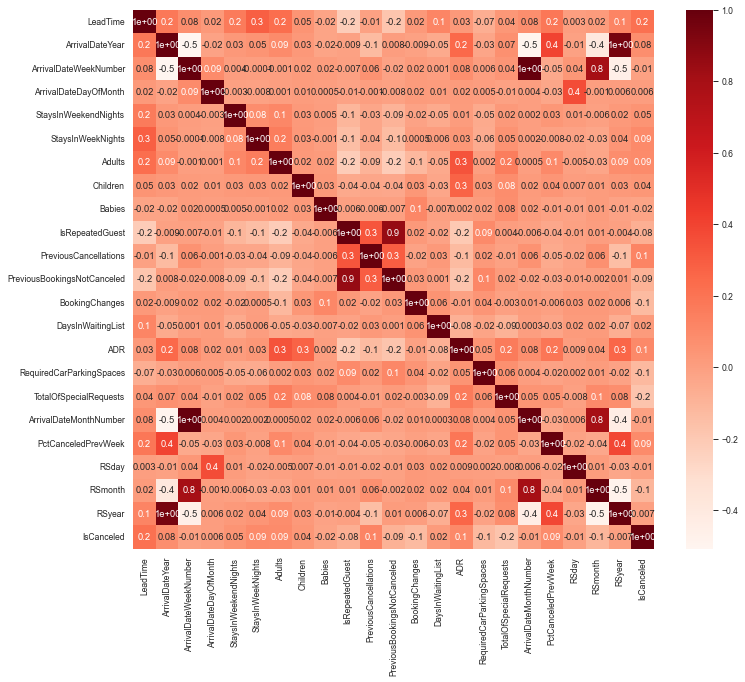

In [78]:
cor_heatmap(cor_spearman)

## Embedded Methods

In [79]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()
reg.fit(X_train_num, y_train)
coef = pd.Series(reg.coef_, index = X_train_num.columns)
coef

LeadTime                       0.000333
ArrivalDateYear                0.970684
ArrivalDateWeekNumber          0.020873
ArrivalDateDayOfMonth         -0.000181
StaysInWeekendNights           0.005201
StaysInWeekNights              0.018607
Adults                         0.000000
Children                      -0.000000
Babies                        -0.000000
IsRepeatedGuest               -0.000000
PreviousCancellations          0.007668
PreviousBookingsNotCanceled   -0.001820
BookingChanges                -0.034972
DaysInWaitingList             -0.000343
ADR                            0.001163
RequiredCarParkingSpaces      -0.015135
TotalOfSpecialRequests        -0.062711
ArrivalDateMonthNumber         0.000000
PctCanceledPrevWeek            0.000000
RSday                         -0.003050
RSmonth                       -0.099531
RSyear                        -0.982399
dtype: float64

In [80]:
gini_importance = DecisionTreeClassifier().fit(X_train_num, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num, y_train).feature_importances_

import seaborn as sns

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train_num.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

<AxesSubplot:xlabel='Value', ylabel='Col'>

In [81]:
##REMOVE BABIES from train and val
X_train.drop('Babies', axis = 1, inplace = True)
X_val.drop('Babies', axis = 1, inplace = True)
X.drop('Babies', axis = 1, inplace = True)

##REMOVE children from train and val
X_train.drop('Children', axis = 1, inplace = True)
X_val.drop('Children', axis = 1, inplace = True)
X.drop('Children', axis = 1, inplace = True)

In [82]:
#ONE HOT ENCODING

#categorical data
categorical_cols = X_train_cat.columns 
categorical_cols2 = X_val_cat.columns 

#import pandas as pd
X_train= pd.get_dummies(X_train, columns = categorical_cols)
X_val= pd.get_dummies(X_val, columns = categorical_cols2)
X= pd.get_dummies(X, columns = categorical_cols2)

## Apply Scaling

In [83]:
def scale_join (scale, features,X_train, X_val, test):
    '''Scale(string): Type of scale. If 'minmax' = MinMaxScaler(), if 'minmax2' = MinMaxScaler(feature_range=(-1,1))
    if 'robust' = RobustScaler(), if 'standard = StandardScaler()'
    features(list): features to use on our data set. If you have 2 or more lists use the + sign
    Return (X_train, X_val)'''
    #Put the right scale
    if scale == 'minmax':
        scale = MinMaxScaler()
    elif scale == 'minmax2':
        scale = MinMaxScaler(feature_range=(-1,1))
    elif scale == 'robust':
        scale = RobustScaler()
    elif scale == 'standard':
        scale = StandardScaler()
    elif scale == None: 
        #Joining the scaled numerical features with the categorical ones
        X_train = pd.DataFrame(X_train[features], columns= features, index = X_train.index).join(X_cat)
        X_val = pd.DataFrame(X_train[features], columns= features, index = X_val.index).join(X_cat)
        test = pd.DataFrame(test[features], columns= features, index = test.index).join(test_cat)
        return(X_train, X_val, test)
    else:
        return(print('wrong input on scale'))
    X_train = X_train[features]
    X_val = X_val[features]
    test = test[features]
    # Fit and Transform your train data by applying the scale that was choose before
    scaled_X_train = scale.fit_transform(X_train)
    # Transform your validation data by applying the scale obtained in the previous command
    scaled_X_val = scale.transform(X_val)
    #Transform your test data by applying the scale obtained in the first command
    scaled_test = scale.transform(test)
    #If scale is robust we decided to apply the min max scaler 2 after
    if scale == 'robust':
        scale = MinMaxScaler(feature_range=(-1,1))
        scaled_X_train = scale.fit_transform(scaled_X_train)
        scaled_X_val = scale.transform(scaled_X_val)
        scaled_test = scale.transform(scaled_test)

    #Joining the scaled numerical features with the categorical ones
    X_train = pd.DataFrame(scaled_X_train, columns= features, index = X_train.index).join(X_cat)
    X_val = pd.DataFrame(scaled_X_val, columns= features, index = X_val.index).join(X_cat)
    test = pd.DataFrame(scaled_test, columns= features, index = test.index).join(test_cat)
        
        
    
    return(X_train, X_val, test)

## Repeated Stratified K Fold

In [84]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1

In [85]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

In [86]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))
    
from sklearn.metrics import classification_report, confusion_matrix

## KNN

In [87]:
from sklearn.model_selection import GridSearchCV

In [105]:
#Grid search to determine the best parameters, this takes ~20 minutes to run.
grid_param = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform','distance'],
    'metric' : ['euclidean', 'manhattan']
}

gs = GridSearchCV(
     KNeighborsClassifier(),
     grid_param,
     verbose = 1,
     cv = 3,
     n_jobs = -1
     )

gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [106]:
gs_results.best_score_

0.8441627894539815

In [107]:
gs_results.best_estimator_

KNeighborsClassifier(metric='manhattan', weights='distance')

In [108]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [109]:
#Applying the best parameters

modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')
modelKNN.fit(X = X_train, y = y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [93]:
#labels_train = modelKNN.predict(X_train)
#labels_val = modelKNN.predict(X_val)
#labels_val

In [94]:
#modelKNN.predict_proba(X_val)

In [110]:
print(modelKNN.score(X_train, y_train))
print(modelKNN.score(X_val, y_val))

1.0
0.8532568005989518


In [100]:
#This is a case of overfitting. Adding code to more accurately assess correct number of neighbors.
#This takes ~20min to run.
numberK_list=np.arange(5,11)
high_score=0
nof=0           
score_list_train =[]
score_list_val =[]
for n in numberK_list:
    model = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_val = model.score(X_val, y_val)
    score_list_train.append(score_train)
    score_list_val.append(score_val)
    
    if(score_val>high_score):
        high_score = score_val
        nof = numberK_list[n-1]
print("Best number of neighbors: %d" %nof)
print("Mean accuracy in validation with %d neighbors: %f" % (nof, high_score))

Best number of neighbors: 9
Mean accuracy in validation with 9 neighbors: 0.834477


In [101]:
#Applying the new n_neighbors.
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
modelKNN.fit(X = X_train, y = y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')

In [111]:
#Assessing new accuracy/F1
print(modelKNN.score(X_train, y_train))
print(modelKNN.score(X_val, y_val))

1.0
0.8532568005989518


In [114]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import time
from sklearn.model_selection import cross_val_score
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

In [116]:
#I stopped this cell after it ran for 2 hours.
#avg_score(modelKNN, X, y, X.columns)

## Regression

In [117]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

In [118]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [120]:
y_pred = log_model.predict(X_val)
y_pred

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [121]:
pred_prob = log_model.predict_proba(X_val)
pred_prob

array([[0.17803906, 0.82196094],
       [0.26270464, 0.73729536],
       [0.7635805 , 0.2364195 ],
       ...,
       [0.83189656, 0.16810344],
       [0.94232688, 0.05767312],
       [0.63130757, 0.36869243]])

In [122]:
log_model.coef_

array([[ 4.40208328e-03,  2.57146004e-02,  4.20940247e-02,
         4.47630072e-04,  4.10097610e-02,  1.25942454e-01,
         1.40397043e-02, -5.92697881e-03,  2.23867986e-02,
        -4.93085807e-02, -7.97528424e-02,  1.39434105e-03,
         5.13379549e-03, -2.41626516e-02, -1.67194968e-01,
         1.01389608e-02,  4.78379827e-03, -4.35783218e-03,
        -2.66351297e-01, -2.64901119e-02, -2.47725617e-02,
         1.29918718e-05, -8.71576082e-03,  3.34874673e-02,
         9.49630412e-06, -2.48566424e-04, -8.32716127e-03,
        -2.84951970e-02,  1.53432697e-03, -3.95638769e-02,
         7.51031149e-02, -9.37472637e-03, -2.90842369e-02,
        -4.65555581e-04,  3.88262937e-02,  1.10361874e-04,
        -3.81666998e-03,  6.91352244e-04,  9.73026535e-06,
         8.18835235e-03, -1.98793240e-03,  1.41781986e-04,
        -3.38750688e-03,  1.73029061e-04,  3.78367433e-02,
        -4.28905168e-03, -1.09652371e-03, -1.55881028e-02,
        -7.42831960e-03, -1.76657162e-03, -5.86267558e-0

In [123]:
from sklearn.metrics import confusion_matrix

In [125]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[10968,   245],
       [ 3707,  1108]], dtype=int64)

In [126]:
from sklearn.metrics import accuracy_score

In [127]:
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.7534314948839531

In [128]:
from sklearn.metrics import precision_score

In [130]:
precision = precision_score(y_val, y_pred)
precision

0.8189209164818921

In [131]:
from sklearn.metrics import recall_score

In [133]:
recall_score(y_val, y_pred)

0.23011422637590861

In [134]:
from sklearn.metrics import f1_score

In [136]:
f1 = f1_score(y_val, y_pred)
f1

0.3592736705577173

In [139]:
#Same issue
avg_score(log_model, X, y, X.columns)

('0.76+/-0.0', '0.76+/-0.0', '0.408+/-0.02', 0.408)